<AxesSubplot:xlabel='wavenumber'>

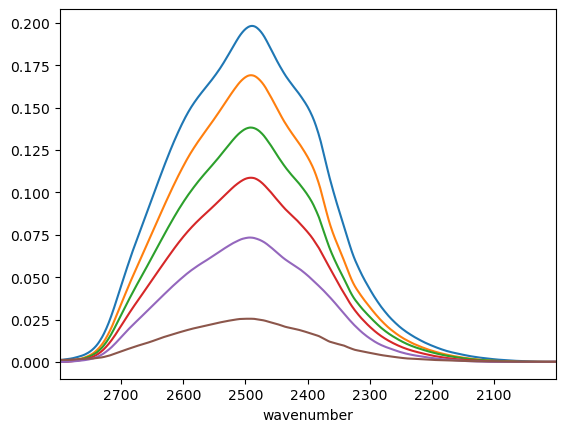

In [31]:
import numpy
import pandas as pd
from matplotlib import pyplot
filename = 'file'
data = pd.read_csv(filename, header=0, index_col=0).T
data.index = pd.read_csv(filename, header=None, index_col=0).iloc[0].values
xmax, xmin = 2800, 2000
data = data.iloc[:, (xmin <= data.columns) & (data.columns <= xmax)]
data.mask(data < 0, 0, inplace=True)
data.T.plot(legend=None, xlim=[data.columns.max(), data.columns.min()])

<AxesSubplot:xlabel='wavenumber'>

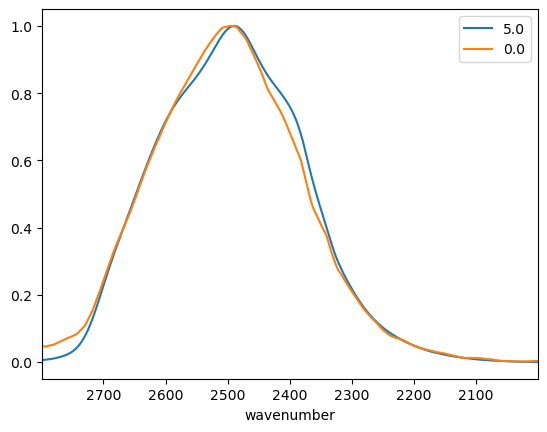

In [32]:
# initial guess (file load)
init_spec = data.iloc[[0, len(data)-1], :]
init_spec.iloc[1, :] = init_spec.iloc[1, :] / init_spec.iloc[1, :].max()
init_spec.iloc[0, :] = init_spec.iloc[0, :] / init_spec.iloc[0, :].max()
init_spec.T.plot(xlim=[data.columns.max(), data.columns.min()])

In [33]:
import numpy as np
import matplotlib.pyplot as plt
# Fast Non-Negative Least Squaresの関数
def fnnls(A, b, tol=1e-11, max_iter=1000):
    m, n = A.shape
    x = np.zeros(n)
    w = A.T @ (b - A @ x)
    P = np.zeros(n, dtype=bool)
    Z = np.ones(n, dtype=bool)
    iter_count = 0
    
    while np.any(Z) and np.any(w[Z] > tol) and iter_count < max_iter:
        t = np.argmax(w)
        P[t] = True
        Z[t] = False
        while True:
            x[P], _, _, _ = np.linalg.lstsq(A[:, P], b, rcond=None)
            if np.all(x[P] >= 0):
                break

            alpha = np.min(x[P] / (x[P] - x))
            x = x + alpha * (x - x)
            x[~P] = 0
            iter_count += 1

        w = A.T @ (b - A @ x)
        iter_count += 1

    return x

In [34]:
# データを生成または読み込みます（ここでは、例としてダミーデータを生成します）
X = data.values  # スペクトルデータセット

# 初期推定値を設定します
num_components = 2  # 分解する成分の数を設定します
S = init_spec.values # 初期推定スペクトル行列
C = np.random.rand(len(data), num_components)  # 初期濃度行列

# 反復回数と収束閾値を設定します
max_iter = 1000
tolerance = 0.1

# 収束まで交互に更新を繰り返します
counter = 0
for iteration in range(max_iter):
    # 前回のスペクトル行列を保存しておく
    S_prev = S.copy()

    # 濃度行列を最適化します（非負制約あり）
    for i in range(X.shape[0]):
        C[i, :] = fnnls(S.T, X[i, :])

    # スペクトル行列を最適化します（非負制約なし）
    S = np.linalg.pinv(C.T @ C) @ C.T @ X

    # 収束判定
    error = np.linalg.norm(S - S_prev)
    if error < tolerance:
        counter += 1
        if counter >= 20:
            break
    else:
        counter = 0


# 濃度行列 C をプロット
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Concentration Matrix (C)")
for i in range(num_components):
    plt.plot(C[:, i], label=f"Component {i+1}")
plt.xlabel("Sample Index")
plt.ylabel("Concentration")
plt.legend()

# スペクトル行列 S をプロット
plt.subplot(1, 2, 2)
plt.title("Spectral Matrix (S)")
for i in range(num_components):
    plt.plot(S[i, :], label=f"Component {i+1}")
plt.xlabel("Wavelength Index")
plt.ylabel("Absorbance")
plt.legend()

plt.tight_layout()
plt.show()

# 空のデータフレームの作成
cols = data.columns
initinal_data = pd.DataFrame(index=['BW', 'IW'], columns=cols)
initinal_data.iloc[0, :] = S[0, :]/max(S[0, :])
initinal_data.iloc[1, :] = S[1, :]/max(S[1, :]) * -1

/Users/chikamishunta/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/chikamishunta/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: 

15


<AxesSubplot:xlabel='wavenumber'>

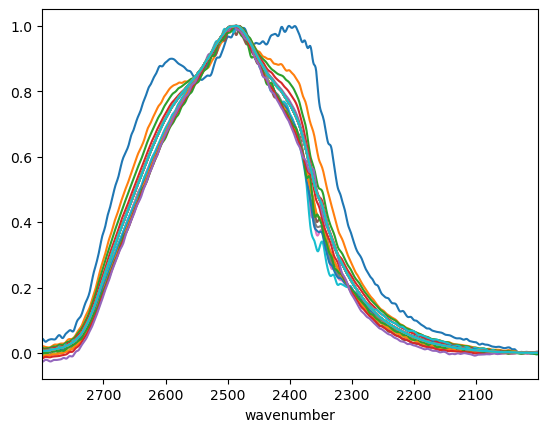

In [ ]:
# 差スペクトルの計算
x = 0
for i in range (len(data)-1):
    x += i + 1
print(x)
m = 0
subtraction_data = pd.DataFrame(columns=range(x*2), index=data.columns)
for i in range (len(data)-1):
    for j in range (len(data)-i-1):
        df = data.iloc[[i, i+j+1], :]
        y = df.values[0] - df.values[1]
        subtraction_data.iloc[:, m] = y / y.max()
        m += 1
for i in range (x):
    subtraction_data.iloc[:, m] = data.iloc[0, :].values / data.iloc[0, :].values.max()
    m += 1
subtraction_data.plot(xlim=[data.columns.max(), data.columns.min()], legend=False)


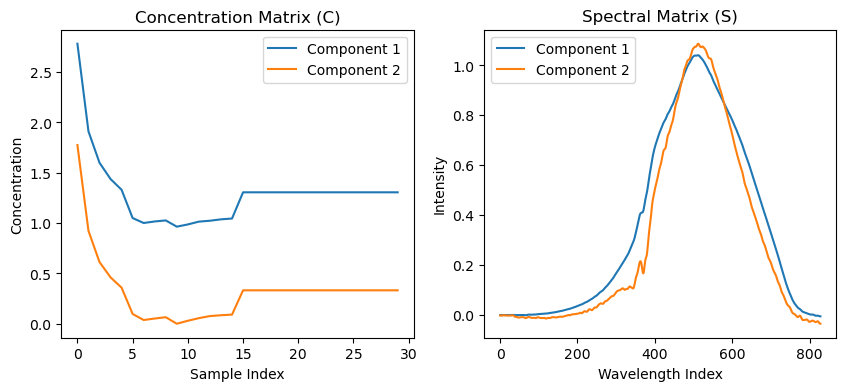

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# データを生成または読み込みます（ここでは、例としてダミーデータを生成します）
X = subtraction_data.T.values.astype(np.float64)

# 初期推定値を設定します
num_components = 2  # 分解する成分の数を設定します
S = initinal_data.values.astype(np.float64)
C = np.random.rand(len(subtraction_data.T), num_components).astype(np.float64)

# 拡大行列を定義します
expansion_matrix = np.array([[1, 1],
                             [1, 0]])

# 反復回数と収束閾値を設定します
max_iter = 1000
tolerance = 0.1

# 収束まで交互に更新を繰り返します
counter = 0
for iteration in range(max_iter):
    # 前回のスペクトル行列を保存しておく
    S_prev = S.copy()

    # 濃度行列を最適化します（拡大行列の制約を適用）
    C = X @ np.linalg.pinv(S.T @ S) @ S.T
    C = C @ np.linalg.pinv(expansion_matrix)
    for i in range(X.shape[0]):
        C[i, :] = fnnls(S.T, X[i, :])

    # スペクトル行列を最適化します（制約なし）
    S = np.linalg.pinv(C.T @ C) @ C.T @ X

    # 収束判定
    error = np.linalg.norm(S - S_prev)
    if error < tolerance:
        counter += 1
        if counter >= 20:
            break
    else:
        counter = 0

# 濃度行列 C をプロット
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Concentration Matrix (C)")
for i in range(num_components):
    plt.plot(C[:, i], label=f"Component {i+1}")
plt.xlabel("Sample Index")
plt.ylabel("Concentration")
plt.legend()

# スペクトル行列 S をプロット
plt.subplot(1, 2, 2)
plt.title("Spectral Matrix (S)")
plt.plot(S[0, :], label=f"Component {1}")
plt.plot(S[1, :]*-1, label=f"Component {2}")
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.legend()

plt.show()

# 空のデータフレームの作成
cols = data.columns
MCR_data = pd.DataFrame(index=['BW', 'IW'], columns=cols)
MCR_data.iloc[0, :] = S[0, :]/max(S[0, :])
MCR_data.iloc[1, :] = S[1, :]/max(S[1, :]) * -1
MCR_data.to_csv("file")
